In [1]:
!pip install gensim pymatgen scikit-learn imbalanced-learn

In [2]:
!git clone https://github.com/materialsintelligence/mat2vec.git

Cloning into 'mat2vec'...
remote: Enumerating objects: 224, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 224 (delta 8), reused 9 (delta 1), pack-reused 198 (from 1)
Receiving objects: 100% (224/224), 55.85 MiB | 10.06 MiB/s, done.
Resolving deltas: 100% (111/111), done.


In [3]:
%cd mat2vec

/content/mat2vec


In [4]:
!pip install .

Processing /content/mat2vec
  Preparing metadata (setup.py) ... done
  Created wheel for mat2vec: filename=mat2vec-0.2-py3-none-any.whl size=16026791 sha256=58395694e7db708ef9182e0d43d9136bad5a7fc64d6f479b89f4d09308c57b98
  Stored in directory: /tmp/pip-ephem-wheel-cache-dbktdo5y/wheels/c6/5d/9b/c7b431912059069b91eb5f52f68da68b3c71676b23d5180bee
Successfully built mat2vec


In [5]:
import os
import math
import random
import numpy as np
import pandas as pd
from typing import Optional, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from gensim.models import Word2Vec
from pymatgen.core import Composition

In [6]:
import os
print("Models available:", os.listdir("mat2vec/training/models"))

Models available: ['.gitignore', 'pretrained_embeddings.trainables.syn1neg.npy', 'pretrained_embeddings.wv.vectors.npy', 'pretrained_embeddings']


In [7]:
w2v_model = Word2Vec.load("mat2vec/training/models/pretrained_embeddings")
print("Al vector shape:", w2v_model.wv['Al'].shape)
print("Al vector (first 10 dims):", w2v_model.wv['Al'][:10])

Al vector shape: (200,)
Al vector (first 10 dims): [-0.11151893 -0.00565871  0.15742345 -0.05287927 -0.3275909  -0.00513005
  0.4634279   0.05334687 -0.23970817 -0.12138384]


In [8]:
def get_element_features(element_symbol: str) -> np.ndarray:
    """
    Get additional element features beyond word2vec embeddings.
    Includes: atomic number, electronegativity, atomic radius, etc.
    """
    from pymatgen.core import Element

    try:
        el = Element(element_symbol)
        features = np.array([
            el.Z,  # atomic number
            el.atomic_mass,
            el.X if el.X else 0.0,  # electronegativity
            el.atomic_radius if el.atomic_radius else 0.0,
            el.average_ionic_radius if el.average_ionic_radius else 0.0,
            el.group,
            el.row,
            float(el.is_metal),
            float(el.is_transition_metal),
            float(el.is_metalloid),
        ])
    except:
        features = np.zeros(10)

    return features

In [9]:
def enhanced_fractional_embedding(fraction, d_model=256):
    d_third = d_model // 3
    positions = np.arange(d_third)

    div_term = np.exp(positions * -(np.log(10000.0) / d_third))
    lin_embed = np.zeros(d_third)
    lin_embed[::2] = np.sin(fraction * math.pi / div_term[::2])
    lin_embed[1::2] = np.cos(fraction * math.pi / div_term[1::2])

    fraction_safe = max(fraction, 1e-6)
    log_scale = np.log10(fraction_safe)
    log_embed = np.zeros(d_third)
    log_embed[::2] = np.sin(log_scale / div_term[::2])
    log_embed[1::2] = np.cos(log_scale / div_term[1::2])

    sqrt_scale = np.sqrt(fraction)
    sqrt_embed = np.zeros(d_model - 2*d_third)
    positions_sqrt = np.arange(len(sqrt_embed))
    div_term_sqrt = np.exp(positions_sqrt * -(np.log(10000.0) / len(sqrt_embed)))
    sqrt_embed[::2] = np.sin(sqrt_scale / div_term_sqrt[::2])
    sqrt_embed[1::2] = np.cos(sqrt_scale / div_term_sqrt[1::2])

    return np.concatenate([lin_embed, log_embed, sqrt_embed])

In [10]:
def formula_to_enhanced_edm(formula, max_elements=5, d_model=768):
    comp = Composition(formula)
    total_atoms = comp.num_atoms
    edm_rows = []

    w2v_dim = 200
    elem_feat_dim = 10
    frac_embed_dim = 256
    remaining_dim = d_model - w2v_dim - elem_feat_dim - frac_embed_dim

    for el, amt in comp.items():
        frac = amt / total_atoms

        try:
            w2v_embed = w2v_model.wv[el.symbol][:w2v_dim]
        except KeyError:
            w2v_embed = np.zeros(w2v_dim)

        if len(w2v_embed) < w2v_dim:
            w2v_embed = np.pad(w2v_embed, (0, w2v_dim - len(w2v_embed)))

        elem_features = get_element_features(el.symbol)[:elem_feat_dim]
        if len(elem_features) < elem_feat_dim:
            elem_features = np.pad(elem_features, (0, elem_feat_dim - len(elem_features)))

        frac_embed = enhanced_fractional_embedding(frac, frac_embed_dim)

        padding = np.zeros(remaining_dim)

        combined = np.concatenate([w2v_embed, elem_features, frac_embed, padding])
        edm_rows.append(combined)

    while len(edm_rows) < max_elements:
        edm_rows.append(np.zeros(d_model))

    return np.array(edm_rows[:max_elements])

In [18]:
formula = "Al2O3"
edm_example = formula_to_enhanced_edm(formula, max_elements=3, d_model=768)

In [19]:
print(f"EDM shape for {formula}:", edm_example.shape)

EDM shape for Al2O3: (3, 768)


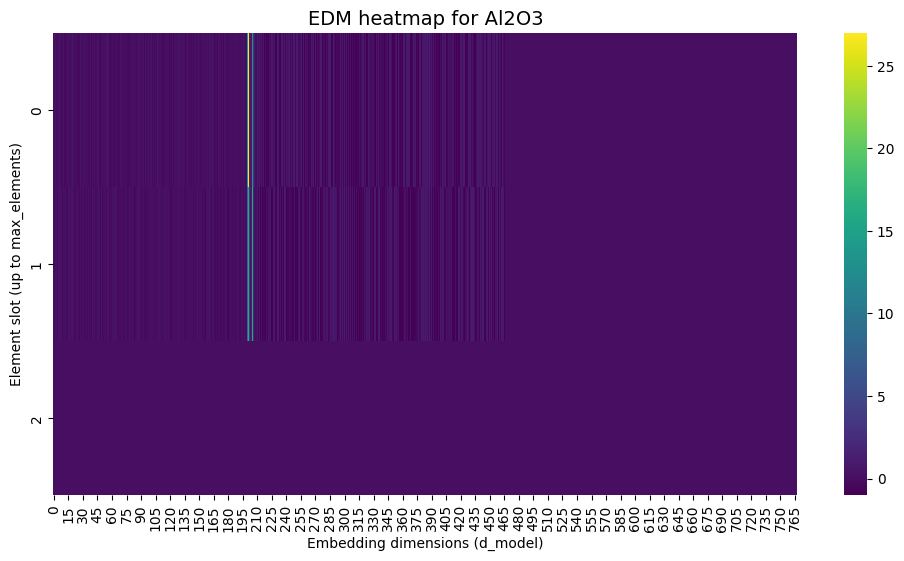

In [20]:
plt.figure(figsize=(12, 6))
sns.heatmap(edm_example, cmap="viridis", cbar=True)

plt.title(f"EDM heatmap for {formula}", fontsize=14)
plt.xlabel("Embedding dimensions (d_model)")
plt.ylabel("Element slot (up to max_elements)")
plt.show()

In [ ]:
df = pd.read_csv("Perovskite_data.csv")
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())

Dataset shape: (4557, 23)
Columns: ['mp_id', 'formula', 'sites', 'composition', 'a_edge (angstrom)', 'b_edge (angstrom)', 'c_edge (angstrom)', 'alpha_ang (deg)', 'beta_ang (deg)', 'gamma_ang (deg)', 'crystal_system', 'space_group', 'total_magnetisation (bohr)', 'energy_per_atom (eV/atom)', 'formation_energy (eV/atom)', 'energy_above_hull (eV/atom)', 'stable', 'density (g/cc)', 'band_gap (eV)', 'direct_bandgap', 'volume (cubic-angstrom)', 'bulk_modulus (GPa)', 'shear_modulus (GPa)']


In [ ]:
REGRESSION_TARGETS = ["band_gap (eV)", "formation_energy (eV/atom)", "density (g/cc)", "volume (cubic-angstrom)"]
CLASSIFICATION_TARGETS = ["stable", "direct_bandgap"]
available_regression = [t for t in REGRESSION_TARGETS if t in df.columns]
available_classification = [t for t in CLASSIFICATION_TARGETS if t in df.columns]
print(f"Available regression targets: {available_regression}")
print(f"Available classification targets: {available_classification}")

Available regression targets: ['band_gap (eV)', 'formation_energy (eV/atom)', 'density (g/cc)', 'volume (cubic-angstrom)']
Available classification targets: ['stable', 'direct_bandgap']


In [ ]:
df["num_elements"] = df["formula"].apply(lambda f: len(Composition(f).elements))
max_elements = max(df["num_elements"].max(), 5)
d_model = 768

print(f"Generating enhanced EDM with d_model={d_model}...")
edm_tensors = []
for idx, f in enumerate(df['formula']):
    if idx % 500 == 0:
        print(f"Processing {idx}/{len(df)}")
    edm_tensors.append(formula_to_enhanced_edm(f, max_elements=max_elements, d_model=d_model))

edm_tensors = np.stack(edm_tensors)
print("Enhanced EDM tensor shape:", edm_tensors.shape)

np.savez("enhanced_dataset_edm.npz", edm=edm_tensors)

Generating enhanced EDM with d_model=768...
Processing 0/4557
Processing 500/4557
Processing 1000/4557
Processing 1500/4557
Processing 2000/4557
Processing 2500/4557
Processing 3000/4557
Processing 3500/4557
Processing 4000/4557
Processing 4500/4557
Enhanced EDM tensor shape: (4557, 5, 768)


In [ ]:
class MultiTaskDataset(Dataset):
    def __init__(self, X, df, regression_targets, classification_targets,
                 standardize=True, fit_stats=None):
        self.X = X.astype("float32")
        self.regression_targets = regression_targets
        self.classification_targets = classification_targets

        self.y_reg = {}
        self.reg_stats = {}

        for target in regression_targets:
            y = df[target].to_numpy().astype("float32").reshape(-1, 1)
            if standardize:
                if fit_stats is None:
                    mean = float(np.mean(y))
                    std = float(np.std(y) + 1e-8)
                else:
                    mean, std = fit_stats['regression'][target]

                self.reg_stats[target] = (mean, std)
                self.y_reg[target] = (y - mean) / std
            else:
                self.y_reg[target] = y
                self.reg_stats[target] = (0.0, 1.0)

        self.y_cls = {}
        self.class_weights = {}

        for target in classification_targets:
            y = df[target].to_numpy().astype("int64")
            self.y_cls[target] = y

            if fit_stats is None:
                class_counts = Counter(y)
                total = len(y)
                weights = {cls: total / (len(class_counts) * count)
                          for cls, count in class_counts.items()}
                self.class_weights[target] = weights
            else:
                self.class_weights[target] = fit_stats['classification'][target]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y_reg = {target: self.y_reg[target][idx] for target in self.regression_targets}
        y_cls = {target: self.y_cls[target][idx] for target in self.classification_targets}
        return x, y_reg, y_cls

    def get_stats(self):
        return {
            'regression': self.reg_stats,
            'classification': self.class_weights
        }

In [ ]:
def make_padding_mask(x_batch: torch.Tensor) -> torch.Tensor:
    pad = (x_batch.abs().sum(dim=-1) == 0)
    return pad

In [ ]:
class MultiHeadAttentionPooling(nn.Module):
    def __init__(self, d_model, num_heads=8):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.d_k = d_model // num_heads

        self.q = nn.Linear(d_model, d_model)
        self.k = nn.Linear(d_model, d_model)
        self.v = nn.Linear(d_model, d_model)
        self.out = nn.Linear(d_model, d_model)

        self.last_attention_weights = None  # For visualization

    def forward(self, x, pad_mask=None, return_attention=False):
        B, L, D = x.shape

        Q = self.q(x).view(B, L, self.num_heads, self.d_k).transpose(1, 2)  # (B, H, L, d_k)
        K = self.k(x).view(B, L, self.num_heads, self.d_k).transpose(1, 2)
        V = self.v(x).view(B, L, self.num_heads, self.d_k).transpose(1, 2)

        query = Q.mean(dim=2, keepdim=True)  # (B, H, 1, d_k)

        scores = torch.matmul(query, K.transpose(-2, -1)) / math.sqrt(self.d_k)  # (B, H, 1, L)

        if pad_mask is not None:
            mask_value = -65000.0 if x.dtype == torch.float16 else -1e9
            scores = scores.masked_fill(pad_mask.unsqueeze(1).unsqueeze(2), mask_value)

        attn_weights = F.softmax(scores, dim=-1)  # (B, H, 1, L)
        self.last_attention_weights = attn_weights.detach()  # Store for visualization

        pooled = torch.matmul(attn_weights, V).squeeze(2)  # (B, H, d_k)
        pooled = pooled.transpose(1, 2).contiguous().view(B, D)  # (B, D)
        pooled = self.out(pooled)

        if return_attention:
            return pooled, attn_weights
        return pooled

In [ ]:
class ElementCrossAttention(nn.Module):
    def __init__(self, d_model, nhead=8, dropout=0.1):
        super().__init__()
        self.cross_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, pad_mask=None):
        # Self-cross-attention
        attn_out, _ = self.cross_attn(x, x, x, key_padding_mask=pad_mask)
        x = self.norm(x + self.dropout(attn_out))
        return x

In [ ]:
class EnhancedEDMTransformer(nn.Module):
    def __init__(self,
                 d_model=768,
                 nhead=12,
                 num_layers=6,
                 dim_ff=2048,
                 dropout=0.15,
                 regression_targets=None,
                 classification_targets=None):
        super().__init__()

        self.d_model = d_model
        self.regression_targets = regression_targets or []
        self.classification_targets = classification_targets or []

        self.input_proj = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Dropout(dropout)
        )

        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model) * 0.02)

        self.element_cross_attn = ElementCrossAttention(d_model, nhead, dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_ff,
            dropout=dropout,
            activation="gelu",
            batch_first=True,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.attn_pool = MultiHeadAttentionPooling(d_model, num_heads=nhead)
        self.max_pool_proj = nn.Linear(d_model, d_model)
        self.mean_pool_proj = nn.Linear(d_model, d_model)

        # Combined feature dimension: CLS + attn_pool + max_pool + mean_pool
        combined_dim = d_model * 4

        # Shared feature extraction
        self.shared_head = nn.Sequential(
            nn.LayerNorm(combined_dim),
            nn.Linear(combined_dim, d_model * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * 2, d_model),
            nn.GELU(),
            nn.Dropout(dropout)
        )

        # Task-specific heads - Regression
        self.regression_heads = nn.ModuleDict()
        for target in self.regression_targets:
            self.regression_heads[target] = nn.Sequential(
                nn.Linear(d_model, d_model // 2),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(d_model // 2, 1)
            )

        # Task-specific heads - Classification
        self.classification_heads = nn.ModuleDict()
        for target in self.classification_targets:
            self.classification_heads[target] = nn.Sequential(
                nn.Linear(d_model, d_model // 2),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(d_model // 2, 2)  # Binary classification
            )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x, return_attention=False):
        # x: (B, L, D)
        B = x.size(0)
        pad_mask = make_padding_mask(x)

        # Input projection
        x = self.input_proj(x)

        # Element cross-attention
        x = self.element_cross_attn(x, pad_mask)

        # Add CLS token
        cls = self.cls_token.expand(B, 1, -1)
        x = torch.cat([cls, x], dim=1)
        pad_mask = torch.cat([torch.zeros(B, 1, dtype=pad_mask.dtype, device=pad_mask.device),
                              pad_mask], dim=1)

        # Transformer encoding
        z = self.encoder(x, src_key_padding_mask=pad_mask)

        cls_vec = z[:, 0, :]  # (B, D)

        if return_attention:
            attn_pooled, attention_weights = self.attn_pool(z, pad_mask, return_attention=True)
        else:
            attn_pooled = self.attn_pool(z, pad_mask)
            attention_weights = None

        # Max pooling (ignoring padding)
        z_masked = z.clone()
        z_masked[pad_mask] = -1e9
        max_pooled = z_masked.max(dim=1)[0]
        max_pooled = self.max_pool_proj(max_pooled)

        # Mean pooling (ignoring padding)
        z_masked_mean = z.clone()
        z_masked_mean[pad_mask] = 0
        mask_sum = (~pad_mask).sum(dim=1, keepdim=True).float()
        mean_pooled = z_masked_mean.sum(dim=1) / mask_sum
        mean_pooled = self.mean_pool_proj(mean_pooled)

        # Combine all pooling strategies
        combined = torch.cat([cls_vec, attn_pooled, max_pooled, mean_pooled], dim=-1)

        # Shared features
        shared_features = self.shared_head(combined)

        # Task-specific predictions
        outputs = {}

        for target in self.regression_targets:
            outputs[f"reg_{target}"] = self.regression_heads[target](shared_features).squeeze(-1)

        for target in self.classification_targets:
            outputs[f"cls_{target}"] = self.classification_heads[target](shared_features)

        if return_attention:
            return outputs, attention_weights
        return outputs


In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
def get_metrics_regression(y_true, y_pred):
    """Calculate regression metrics."""
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2) + 1e-12
    r2 = 1 - ss_res / ss_tot
    return {"MAE": float(mae), "RMSE": float(rmse), "R2": float(r2)}

In [ ]:
def get_metrics_classification(y_true, y_pred):
    """Calculate classification metrics."""
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)

    return {
        "Accuracy": float(acc),
        "F1": float(f1),
        "Precision": float(precision),
        "Recall": float(recall)
    }

In [ ]:
available_regression = ["band_gap (eV)"]
available_classification = ["stable"]

In [ ]:
edm = np.load("enhanced_dataset_edm.npz")["edm"]

In [ ]:
train_idx, temp_idx = train_test_split(range(len(df)), test_size=0.2, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

In [ ]:
train_dataset = MultiTaskDataset(
    edm[train_idx],
    df.iloc[train_idx].reset_index(drop=True),
    available_regression,
    available_classification,
    standardize=True
)

In [ ]:
train_stats = train_dataset.get_stats()

In [ ]:
val_dataset = MultiTaskDataset(
    edm[val_idx],
    df.iloc[val_idx].reset_index(drop=True),
    available_regression,
    available_classification,
    standardize=True,
    fit_stats=train_stats
)

In [ ]:
test_dataset = MultiTaskDataset(
    edm[test_idx],
    df.iloc[test_idx].reset_index(drop=True),
    available_regression,
    available_classification,
    standardize=True,
    fit_stats=train_stats
)

In [ ]:
def collate_fn(batch):
    xs, y_regs, y_clss = zip(*batch)
    xs = torch.tensor(np.stack(xs), dtype=torch.float32)

    y_reg_dict = {}
    for target in available_regression:
        y_reg_dict[target] = torch.tensor([y[target] for y in y_regs], dtype=torch.float32).squeeze()

    y_cls_dict = {}
    for target in available_classification:
        y_cls_dict[target] = torch.tensor([y[target] for y in y_clss], dtype=torch.long)

    return xs, y_reg_dict, y_cls_dict

In [ ]:
BATCH_SIZE = 32  # Reduced for larger model
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                         collate_fn=collate_fn, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                       collate_fn=collate_fn, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        collate_fn=collate_fn, num_workers=0)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
set_seed(42)

model = EnhancedEDMTransformer(
    d_model=768,
    nhead=12,
    num_layers=6,
    dim_ff=2048,
    dropout=0.15,
    regression_targets=available_regression,
    classification_targets=available_classification
).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Loss functions
regression_loss_fn = nn.SmoothL1Loss(beta=0.5)
classification_loss_fn = FocalLoss(alpha=0.25, gamma=2.0)

# Optimizer with differential learning rates
backbone_params = []
head_params = []

for name, param in model.named_parameters():
    if 'regression_heads' in name or 'classification_heads' in name:
        head_params.append(param)
    else:
        backbone_params.append(param)

optimizer = torch.optim.AdamW([
    {'params': backbone_params, 'lr': 1e-4, 'weight_decay': 1e-4},
    {'params': head_params, 'lr': 3e-4, 'weight_decay': 1e-5}
])

# Learning rate scheduler with warmup
EPOCHS = 150
warmup_epochs = 10

def get_lr_lambda(epoch):
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs
    else:
        # Cosine annealing
        progress = (epoch - warmup_epochs) / (EPOCHS - warmup_epochs)
        return 0.5 * (1 + math.cos(math.pi * progress))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda)

# Loss weights for multi-task learning (learnable)
task_weights = {
    f"reg_{t}": nn.Parameter(torch.tensor(1.0)) for t in available_regression
}
task_weights.update({
    f"cls_{t}": nn.Parameter(torch.tensor(1.0)) for t in available_classification
})


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Model parameters: 46,378,757


In [ ]:
def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    reg_losses = {t: [] for t in available_regression}
    cls_losses = {t: [] for t in available_classification}

    reg_preds = {t: [] for t in available_regression}
    reg_trues = {t: [] for t in available_regression}
    cls_preds = {t: [] for t in available_classification}
    cls_trues = {t: [] for t in available_classification}

    for batch_idx, (x, y_reg, y_cls) in enumerate(loader):
        x = x.to(device)
        for t in available_regression:
            y_reg[t] = y_reg[t].to(device)
        for t in available_classification:
            y_cls[t] = y_cls[t].to(device)

        # Forward pass
        outputs = model(x)

        # Calculate losses
        loss = 0

        # Regression losses
        for target in available_regression:
            pred = outputs[f"reg_{target}"]
            true = y_reg[target]
            reg_loss = regression_loss_fn(pred, true)
            loss += reg_loss
            reg_losses[target].append(reg_loss.item())

            reg_preds[target].append(pred.detach().cpu().numpy())
            reg_trues[target].append(true.detach().cpu().numpy())

        # Classification losses
        for target in available_classification:
            pred = outputs[f"cls_{target}"]
            true = y_cls[target]
            cls_loss = classification_loss_fn(pred, true)
            loss += cls_loss
            cls_losses[target].append(cls_loss.item())

            cls_preds[target].append(pred.argmax(dim=1).detach().cpu().numpy())
            cls_trues[target].append(true.detach().cpu().numpy())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    # Aggregate predictions
    for t in available_regression:
        reg_preds[t] = np.concatenate(reg_preds[t])
        reg_trues[t] = np.concatenate(reg_trues[t])

    for t in available_classification:
        cls_preds[t] = np.concatenate(cls_preds[t])
        cls_trues[t] = np.concatenate(cls_trues[t])

    return total_loss / len(loader), reg_losses, cls_losses, reg_preds, reg_trues, cls_preds, cls_trues

In [ ]:
def evaluate(model, loader, device):
    model.eval()
    total_loss = 0
    reg_losses = {t: [] for t in available_regression}
    cls_losses = {t: [] for t in available_classification}

    reg_preds = {t: [] for t in available_regression}
    reg_trues = {t: [] for t in available_regression}
    cls_preds = {t: [] for t in available_classification}
    cls_trues = {t: [] for t in available_classification}

    with torch.no_grad():
        for x, y_reg, y_cls in loader:
            x = x.to(device)
            for t in available_regression:
                y_reg[t] = y_reg[t].to(device)
            for t in available_classification:
                y_cls[t] = y_cls[t].to(device)

            outputs = model(x)

            loss = 0

            for target in available_regression:
                pred = outputs[f"reg_{target}"]
                true = y_reg[target]
                reg_loss = regression_loss_fn(pred, true)
                loss += reg_loss
                reg_losses[target].append(reg_loss.item())

                reg_preds[target].append(pred.cpu().numpy())
                reg_trues[target].append(true.cpu().numpy())

            for target in available_classification:
                pred = outputs[f"cls_{target}"]
                true = y_cls[target]
                cls_loss = classification_loss_fn(pred, true)
                loss += cls_loss
                cls_losses[target].append(cls_loss.item())

                cls_preds[target].append(pred.argmax(dim=1).cpu().numpy())
                cls_trues[target].append(true.cpu().numpy())

            total_loss += loss.item()

    for t in available_regression:
        reg_preds[t] = np.concatenate(reg_preds[t])
        reg_trues[t] = np.concatenate(reg_trues[t])

    for t in available_classification:
        cls_preds[t] = np.concatenate(cls_preds[t])
        cls_trues[t] = np.concatenate(cls_trues[t])

    return total_loss / len(loader), reg_losses, cls_losses, reg_preds, reg_trues, cls_preds, cls_trues

In [ ]:
best_val_loss = float('inf')
patience = 20
patience_counter = 0

history = {
    'train_loss': [],
    'val_loss': [],
    'train_metrics': {t: [] for t in available_regression + available_classification},
    'val_metrics': {t: [] for t in available_regression + available_classification}
}

print("Starting training...")
for epoch in range(1, EPOCHS + 1):
    # Train
    train_loss, train_reg_losses, train_cls_losses, train_reg_preds, train_reg_trues, train_cls_preds, train_cls_trues = train_epoch(
        model, train_loader, optimizer, device
    )

    # Validate
    val_loss, val_reg_losses, val_cls_losses, val_reg_preds, val_reg_trues, val_cls_preds, val_cls_trues = evaluate(
        model, val_loader, device
    )

    scheduler.step()

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    # Print epoch summary
    print(f"\nEpoch {epoch}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Regression metrics
    for target in available_regression:
        # De-standardize
        mean, std = train_stats['regression'][target]
        train_true_orig = train_reg_trues[target] * std + mean
        train_pred_orig = train_reg_preds[target] * std + mean
        val_true_orig = val_reg_trues[target] * std + mean
        val_pred_orig = val_reg_preds[target] * std + mean

        train_metrics = get_metrics_regression(train_true_orig, train_pred_orig)
        val_metrics = get_metrics_regression(val_true_orig, val_pred_orig)

        print(f"\n{target}:")
        print(f"  Train - MAE: {train_metrics['MAE']:.4f}, RMSE: {train_metrics['RMSE']:.4f}, R²: {train_metrics['R2']:.4f}")
        print(f"  Val   - MAE: {val_metrics['MAE']:.4f}, RMSE: {val_metrics['RMSE']:.4f}, R²: {val_metrics['R2']:.4f}")

        history['train_metrics'][target].append(train_metrics)
        history['val_metrics'][target].append(val_metrics)

    # Classification metrics
    for target in available_classification:
        train_metrics = get_metrics_classification(train_cls_trues[target], train_cls_preds[target])
        val_metrics = get_metrics_classification(val_cls_trues[target], val_cls_preds[target])

        print(f"\n{target}:")
        print(f"  Train - Acc: {train_metrics['Accuracy']:.4f}, F1: {train_metrics['F1']:.4f}")
        print(f"  Val   - Acc: {val_metrics['Accuracy']:.4f}, F1: {val_metrics['F1']:.4f}")

        history['train_metrics'][target].append(train_metrics)
        history['val_metrics'][target].append(val_metrics)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_stats': train_stats,
            'val_loss': val_loss
        }, 'best_multitask_model.pt')
        print("✓ Model saved!")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch}")
            break

# ============================================================================
# FINAL EVALUATION ON TEST SET
# ============================================================================

print("\n" + "="*80)
print("FINAL EVALUATION ON TEST SET")
print("="*80)

Starting training...


/tmp/ipython-input-1895440361.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  y_reg_dict[target] = torch.tensor([y[target] for y in y_regs], dtype=torch.float32).squeeze()



Epoch 1/150
Train Loss: 0.6137 | Val Loss: 0.5442

band_gap (eV):
  Train - MAE: 1.2203, RMSE: 1.6529, R²: -0.1145
  Val   - MAE: 1.0444, RMSE: 1.6327, R²: -0.1644

stable:
  Train - Acc: 0.7078, F1: 0.6880
  Val   - Acc: 0.7281, F1: 0.6135
✓ Model saved!

Epoch 2/150
Train Loss: 0.5671 | Val Loss: 0.5329

band_gap (eV):
  Train - MAE: 1.1577, RMSE: 1.5837, R²: -0.0231
  Val   - MAE: 0.9817, RMSE: 1.6116, R²: -0.1344

stable:
  Train - Acc: 0.7539, F1: 0.7056
  Val   - Acc: 0.7346, F1: 0.7010
✓ Model saved!

Epoch 3/150
Train Loss: 0.5494 | Val Loss: 0.4845

band_gap (eV):
  Train - MAE: 1.1236, RMSE: 1.5653, R²: 0.0004
  Val   - MAE: 0.9979, RMSE: 1.4297, R²: 0.1071

stable:
  Train - Acc: 0.7564, F1: 0.7084
  Val   - Acc: 0.7281, F1: 0.6135
✓ Model saved!

Epoch 4/150
Train Loss: 0.5403 | Val Loss: 0.5087

band_gap (eV):
  Train - MAE: 1.1099, RMSE: 1.5487, R²: 0.0216
  Val   - MAE: 0.9962, RMSE: 1.5104, R²: 0.0036

stable:
  Train - Acc: 0.7621, F1: 0.7076
  Val   - Acc: 0.7281, F1

In [ ]:
checkpoint = torch.load('best_multitask_model.pt', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])

test_loss, test_reg_losses, test_cls_losses, test_reg_preds, test_reg_trues, test_cls_preds, test_cls_trues = evaluate(
    model, test_loader, device
)

print(f"\nTest Loss: {test_loss:.4f}\n")


Test Loss: 0.1910



band_gap (eV):
  MAE:  0.4267
  RMSE: 0.7741
  R²:   0.7211


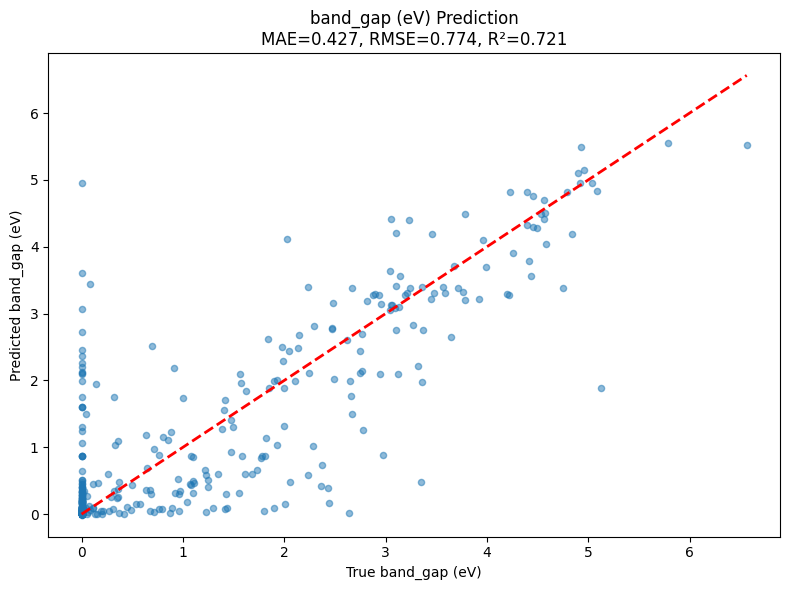

In [ ]:
for target in available_regression:
    mean, std = train_stats['regression'][target]
    test_true_orig = test_reg_trues[target] * std + mean
    test_pred_orig = test_reg_preds[target] * std + mean

    metrics = get_metrics_regression(test_true_orig, test_pred_orig)

    print(f"{target}:")
    print(f"  MAE:  {metrics['MAE']:.4f}")
    print(f"  RMSE: {metrics['RMSE']:.4f}")
    print(f"  R²:   {metrics['R2']:.4f}")

    # Scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(test_true_orig, test_pred_orig, alpha=0.5, s=20)
    plt.plot([test_true_orig.min(), test_true_orig.max()],
             [test_true_orig.min(), test_true_orig.max()],
             'r--', lw=2)
    plt.xlabel(f'True {target}')
    plt.ylabel(f'Predicted {target}')
    plt.title(f'{target} Prediction\nMAE={metrics["MAE"]:.3f}, RMSE={metrics["RMSE"]:.3f}, R²={metrics["R2"]:.3f}')
    plt.tight_layout()
    plt.savefig(f'test_{target.replace(" ", "_")}_scatter.png', dpi=300)
    plt.show()



stable:
  Accuracy:  0.7741
  F1 Score:  0.7405
  Precision: 0.7450
  Recall:    0.7741


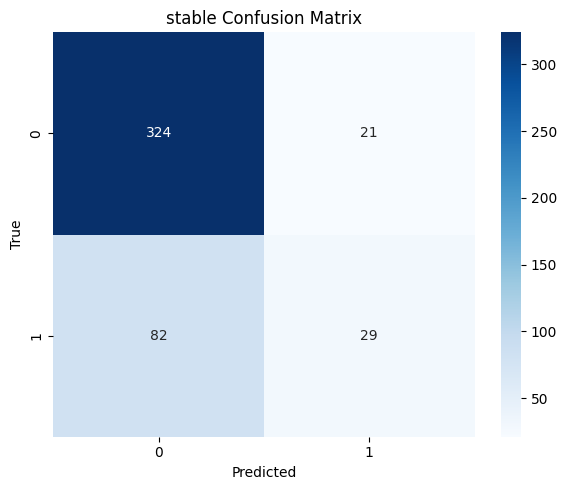


Classification Report for stable:
              precision    recall  f1-score   support

           0       0.80      0.94      0.86       345
           1       0.58      0.26      0.36       111

    accuracy                           0.77       456
   macro avg       0.69      0.60      0.61       456
weighted avg       0.74      0.77      0.74       456



In [ ]:
for target in available_classification:
    metrics = get_metrics_classification(test_cls_trues[target], test_cls_preds[target])

    print(f"\n{target}:")
    print(f"  Accuracy:  {metrics['Accuracy']:.4f}")
    print(f"  F1 Score:  {metrics['F1']:.4f}")
    print(f"  Precision: {metrics['Precision']:.4f}")
    print(f"  Recall:    {metrics['Recall']:.4f}")

    # Confusion matrix
    cm = confusion_matrix(test_cls_trues[target], test_cls_preds[target])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{target} Confusion Matrix')
    plt.tight_layout()
    plt.savefig(f'test_{target}_confusion_matrix.png', dpi=300)
    plt.show()

    # Classification report
    print(f"\nClassification Report for {target}:")
    print(classification_report(test_cls_trues[target], test_cls_preds[target]))



Analyzing: CaTiO3


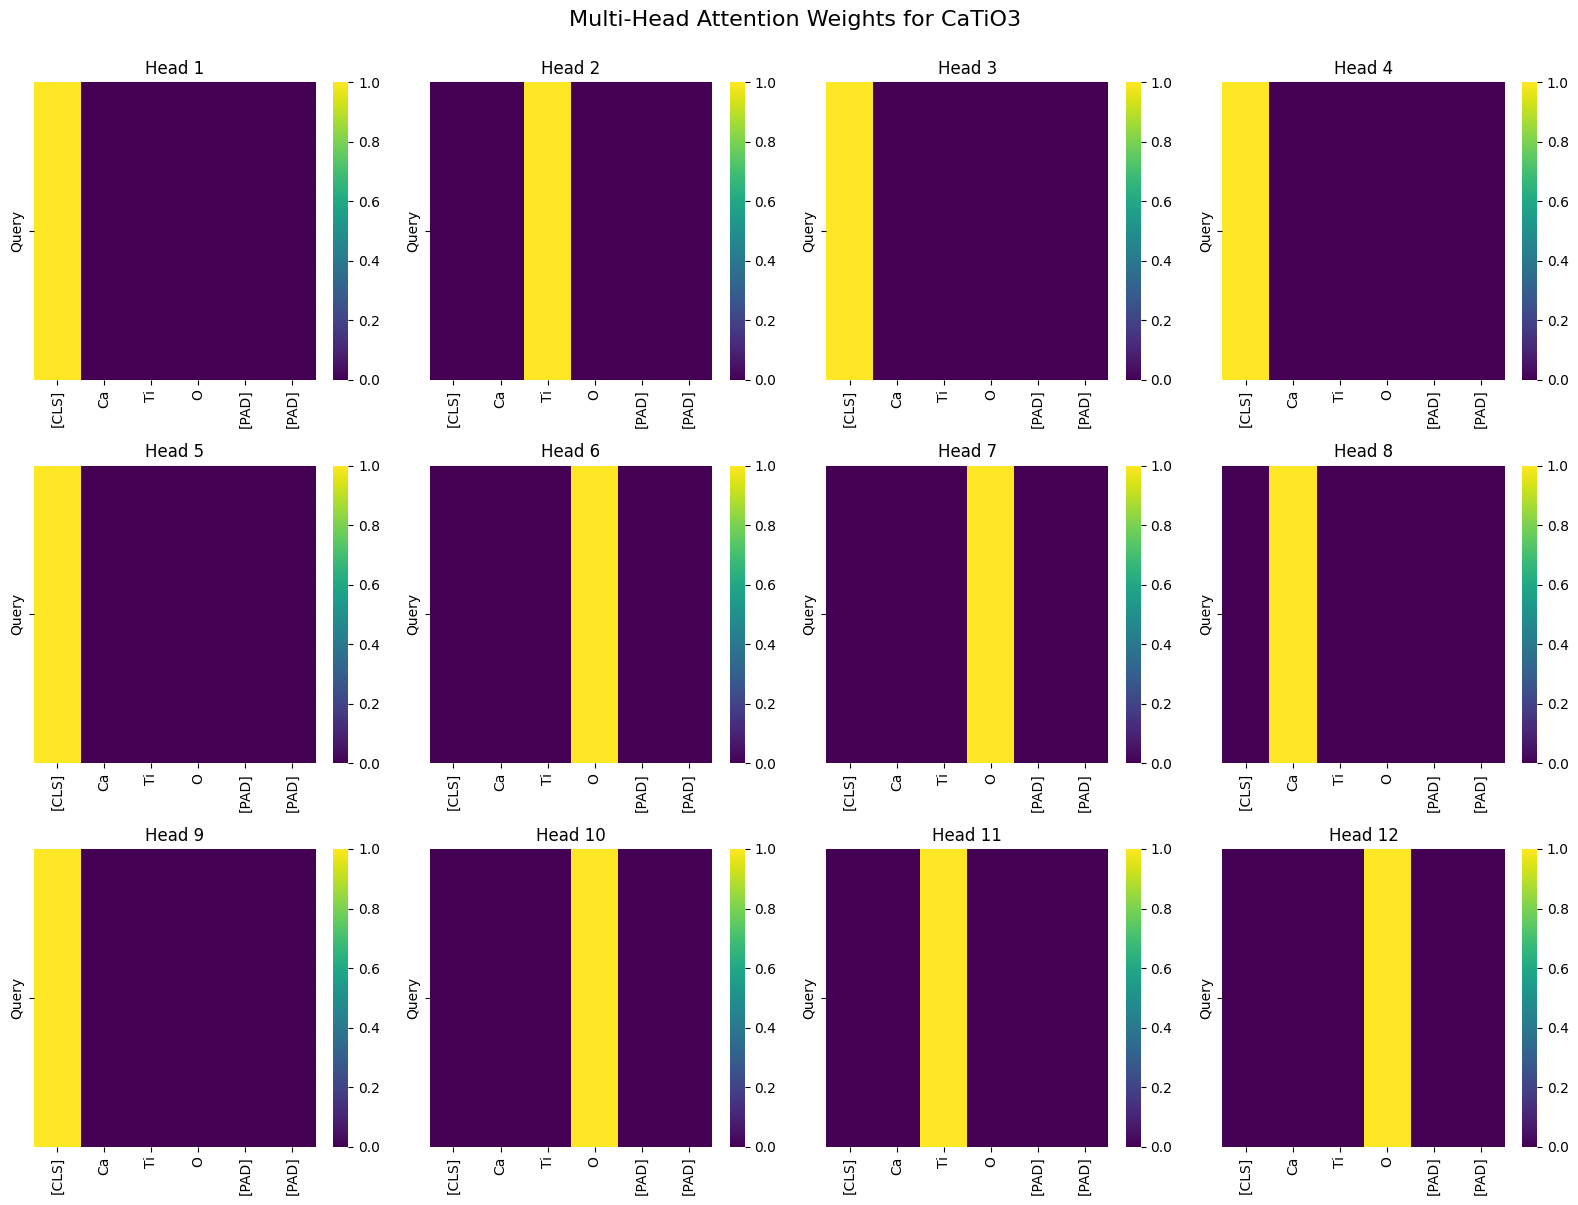

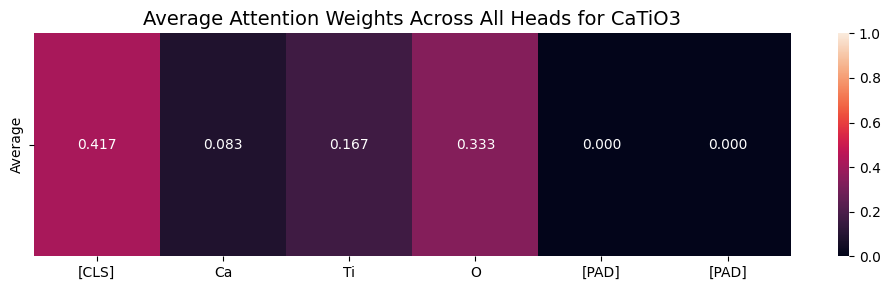


Predictions for CaTiO3:
  band_gap (eV): 2.4864
  stable: Class 0 (prob: 0.6286)

Analyzing: BaTiO3


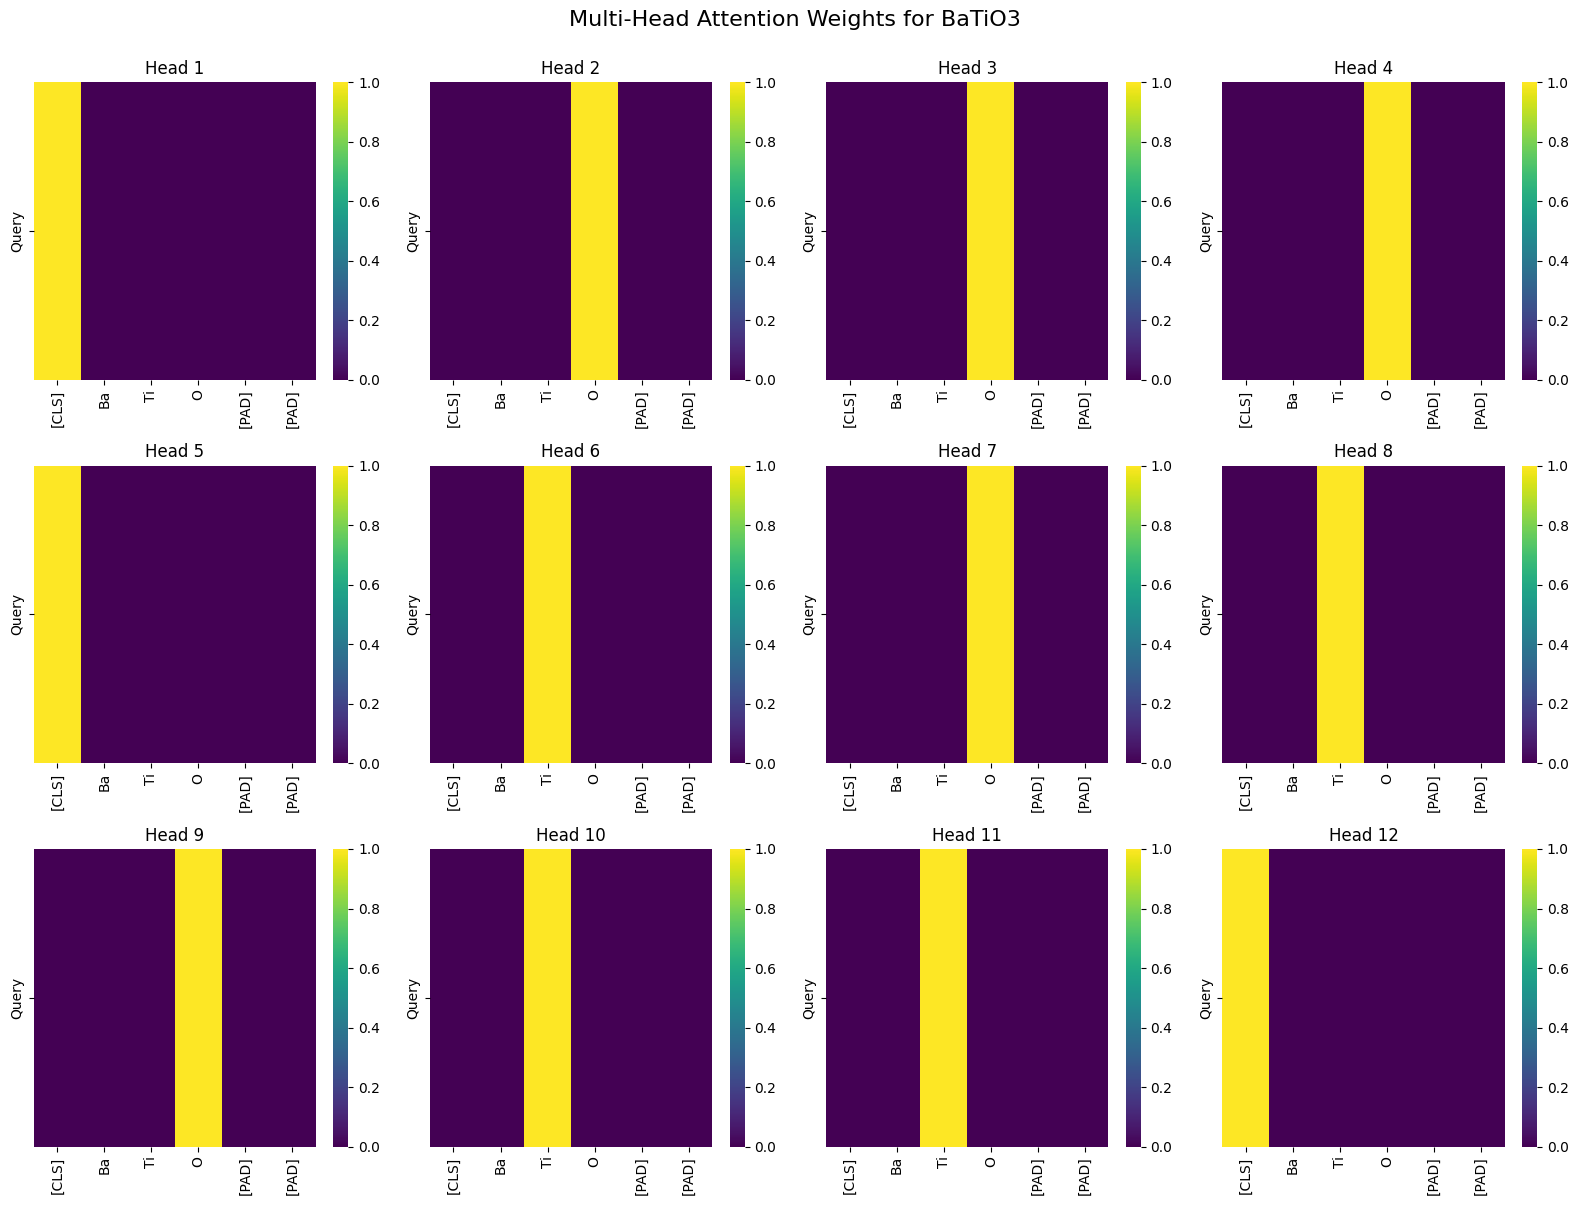

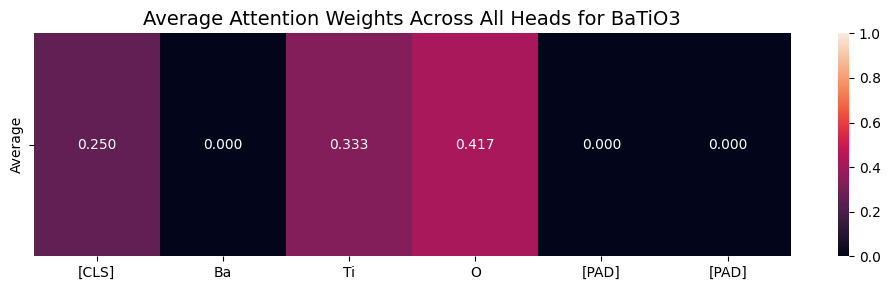


Predictions for BaTiO3:
  band_gap (eV): 1.2497
  stable: Class 0 (prob: 0.6392)

Analyzing: SrTiO3


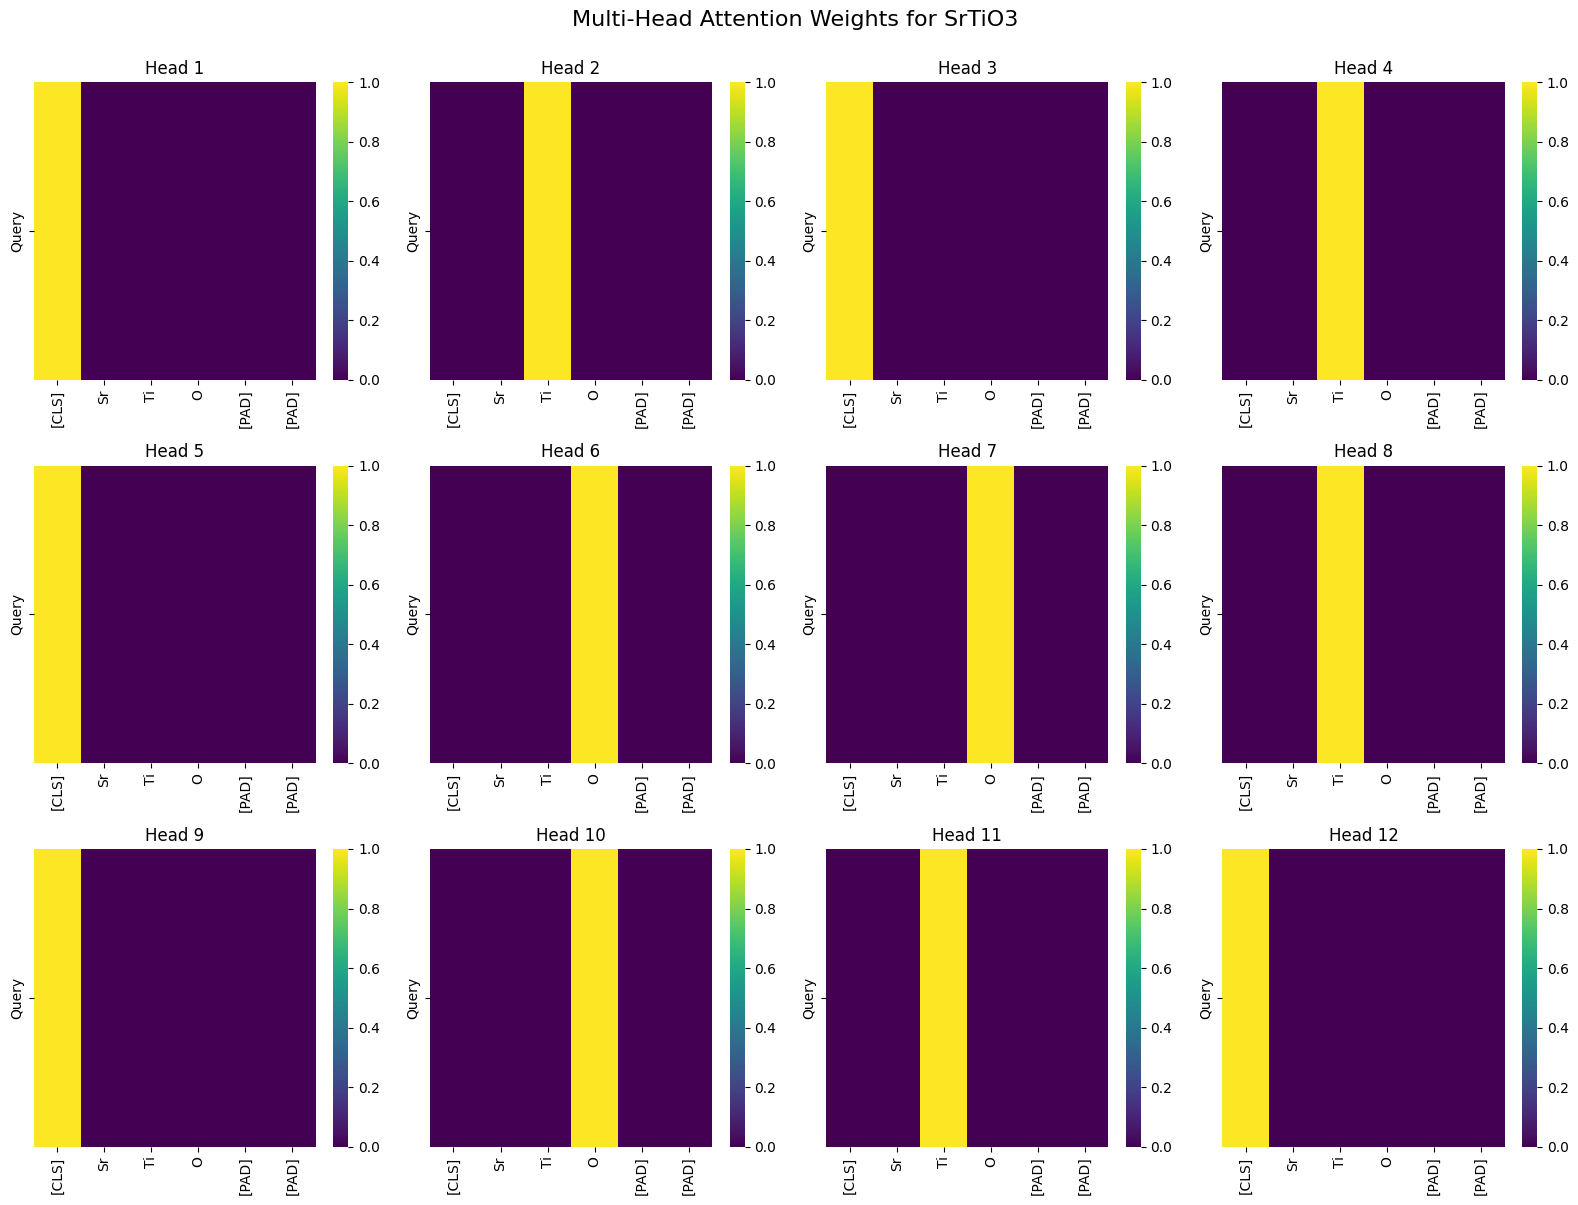

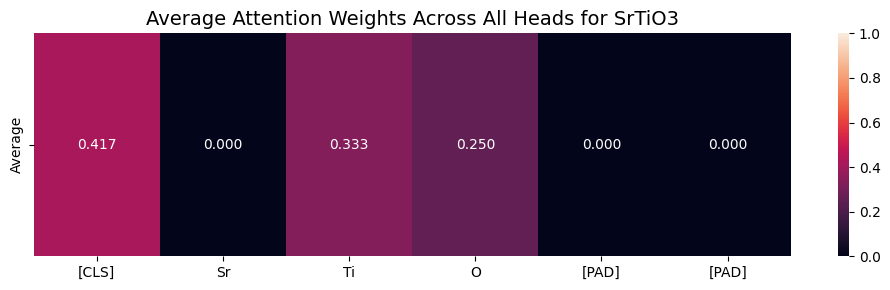


Predictions for SrTiO3:
  band_gap (eV): 2.2402
  stable: Class 0 (prob: 0.6191)

Analyzing: Al2O3


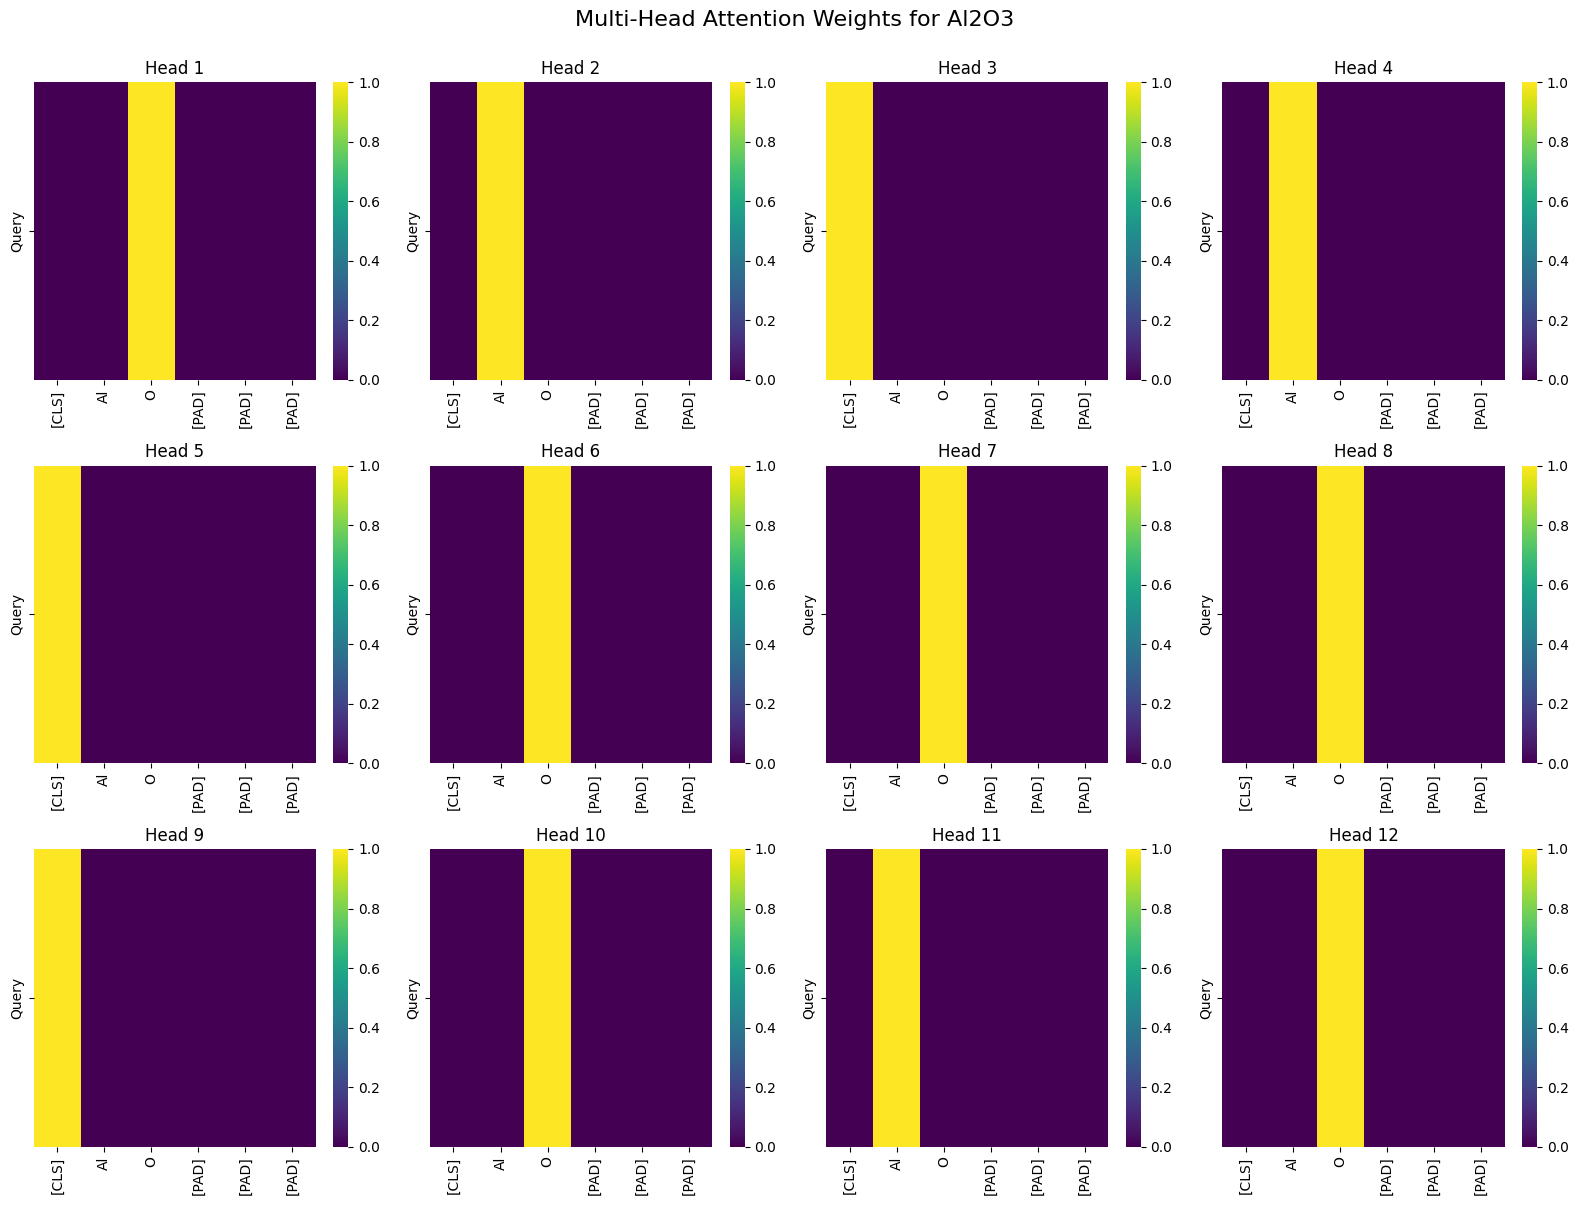

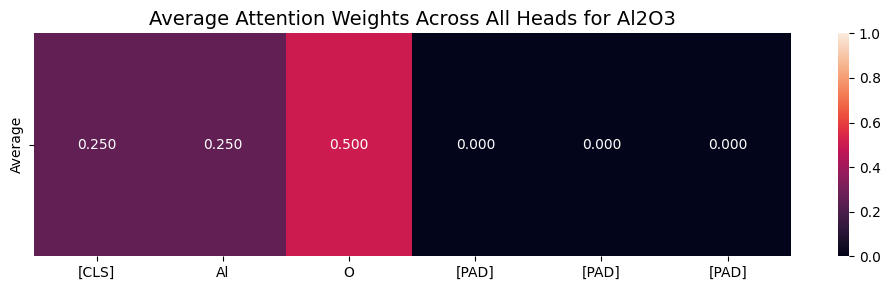


Predictions for Al2O3:
  band_gap (eV): 3.3971
  stable: Class 0 (prob: 0.6584)

Analyzing: Fe2O3


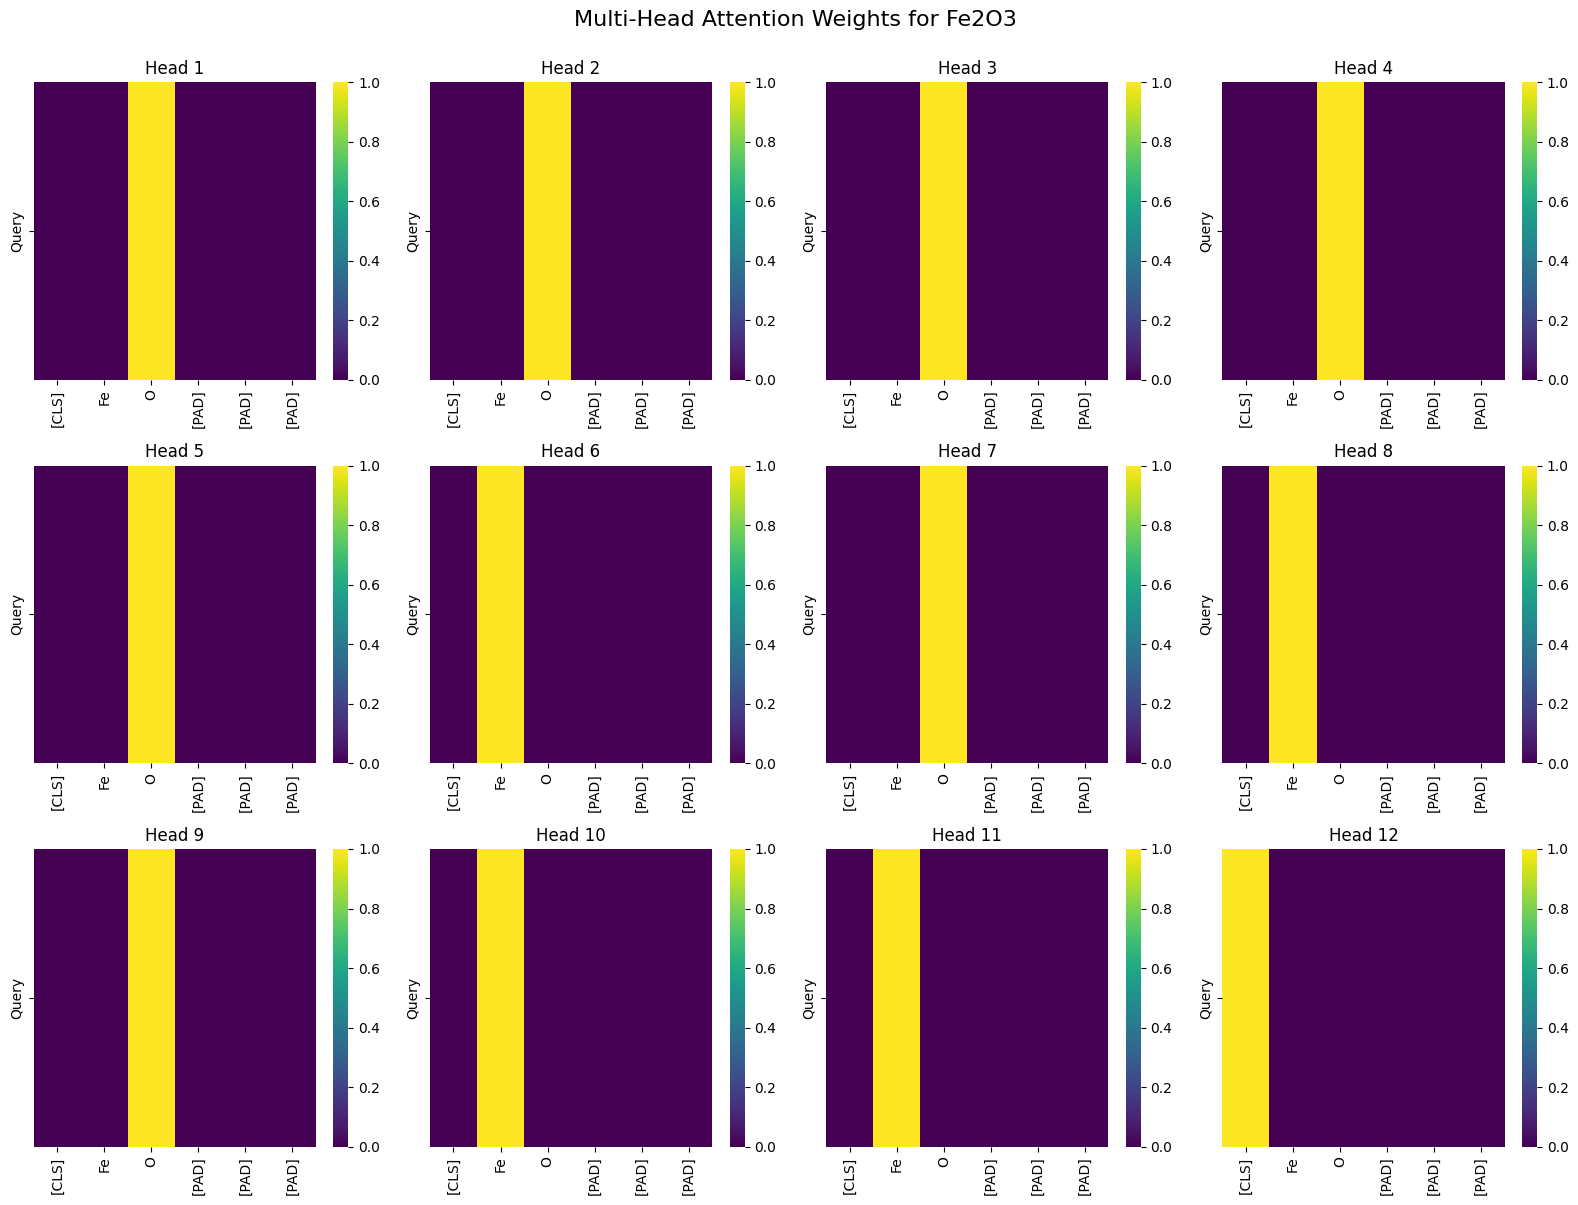

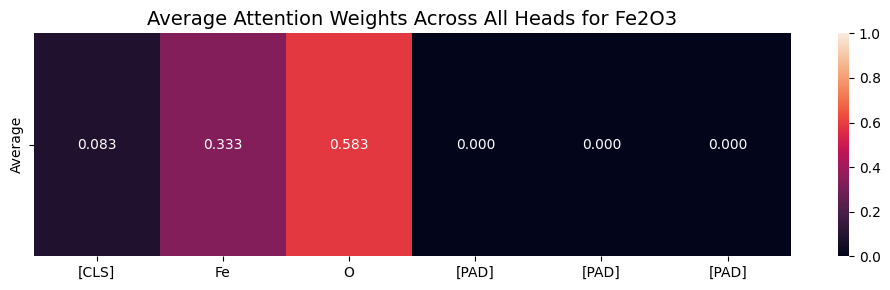


Predictions for Fe2O3:
  band_gap (eV): 0.4942
  stable: Class 0 (prob: 0.7086)


In [ ]:
def visualize_attention_for_compound(formula, model, device, max_elements=5, d_model=768):
    """
    Visualize self-attention weights for a specific compound.
    """
    model.eval()

    # Generate EDM
    edm = formula_to_enhanced_edm(formula, max_elements=max_elements, d_model=d_model)
    edm_tensor = torch.tensor(edm, dtype=torch.float32).unsqueeze(0).to(device)  # (1, L, D)

    # Get predictions and attention weights
    with torch.no_grad():
        outputs, attention_weights = model(edm_tensor, return_attention=True)

    # Extract attention weights (B, H, 1, L)
    attn = attention_weights.squeeze(0).squeeze(1).cpu().numpy()  # (H, L)
    attn_mean = attn.mean(axis=0)  # Average across heads

    # Get element composition
    comp = Composition(formula)
    elements = list(comp.as_dict().keys())

    # Pad element names
    element_names = elements + ['[PAD]'] * (max_elements - len(elements))
    element_names = ['[CLS]'] + element_names  # Add CLS token

    # Plot attention heatmap across all heads
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    num_heads = attn.shape[0]

    for head_idx in range(min(num_heads, 12)):
        ax = axes[head_idx // 4, head_idx % 4]
        sns.heatmap(attn[head_idx:head_idx+1, :len(element_names)],
                   xticklabels=element_names,
                   yticklabels=['Query'],
                   cmap='viridis',
                   ax=ax,
                   cbar=True,
                   vmin=0,
                   vmax=1)
        ax.set_title(f'Head {head_idx + 1}')

    plt.suptitle(f'Multi-Head Attention Weights for {formula}', fontsize=16, y=1.00)
    plt.tight_layout()
    plt.savefig(f'attention_{formula.replace(" ", "_")}_all_heads.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Plot averaged attention
    plt.figure(figsize=(10, 3))
    sns.heatmap(attn_mean[:len(element_names)].reshape(1, -1),
               xticklabels=element_names,
               yticklabels=['Average'],
               cmap='rocket',
               annot=True,
               fmt='.3f',
               cbar=True,
               vmin=0,
               vmax=1)
    plt.title(f'Average Attention Weights Across All Heads for {formula}', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'attention_{formula.replace(" ", "_")}_average.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print predictions
    print(f"\nPredictions for {formula}:")
    for target in available_regression:
        pred_std = outputs[f"reg_{target}"].item()
        mean, std = train_stats['regression'][target]
        pred_orig = pred_std * std + mean
        print(f"  {target}: {pred_orig:.4f}")

    for target in available_classification:
        logits = outputs[f"cls_{target}"].cpu().numpy()[0]
        probs = torch.softmax(torch.tensor(logits), dim=0).numpy()
        pred_class = logits.argmax()
        print(f"  {target}: Class {pred_class} (prob: {probs[pred_class]:.4f})")

# Visualize attention for example compounds
example_formulas = ["CaTiO3", "BaTiO3", "SrTiO3", "Al2O3", "Fe2O3"]

for formula in example_formulas:
    try:
        print(f"\n{'='*80}")
        print(f"Analyzing: {formula}")
        print('='*80)
        visualize_attention_for_compound(formula, model, device, max_elements, d_model)
    except Exception as e:
        print(f"Error analyzing {formula}: {e}")


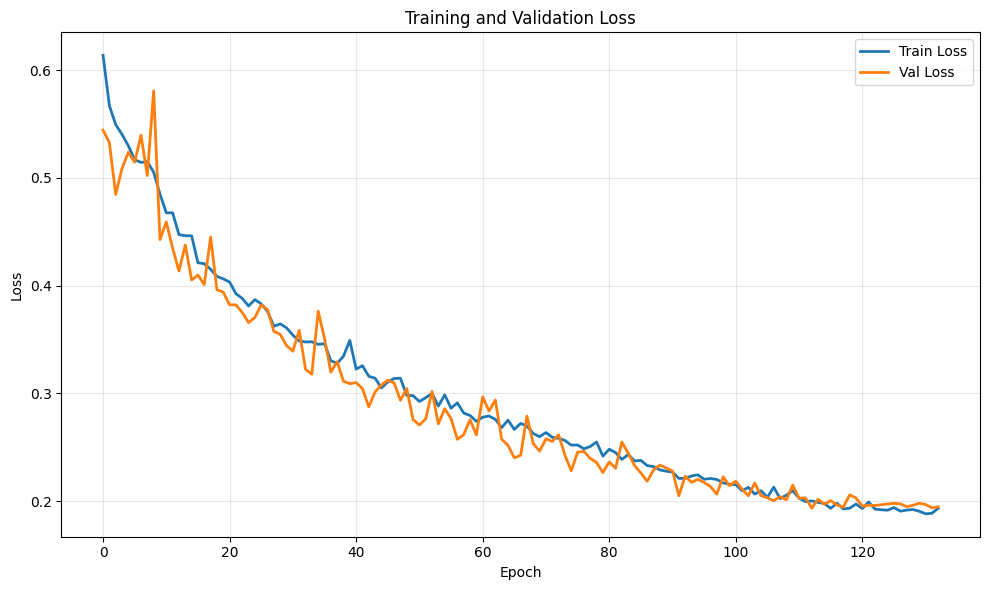

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Train Loss', linewidth=2)
plt.plot(history['val_loss'], label='Val Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('loss_curves.png', dpi=300)
plt.show()

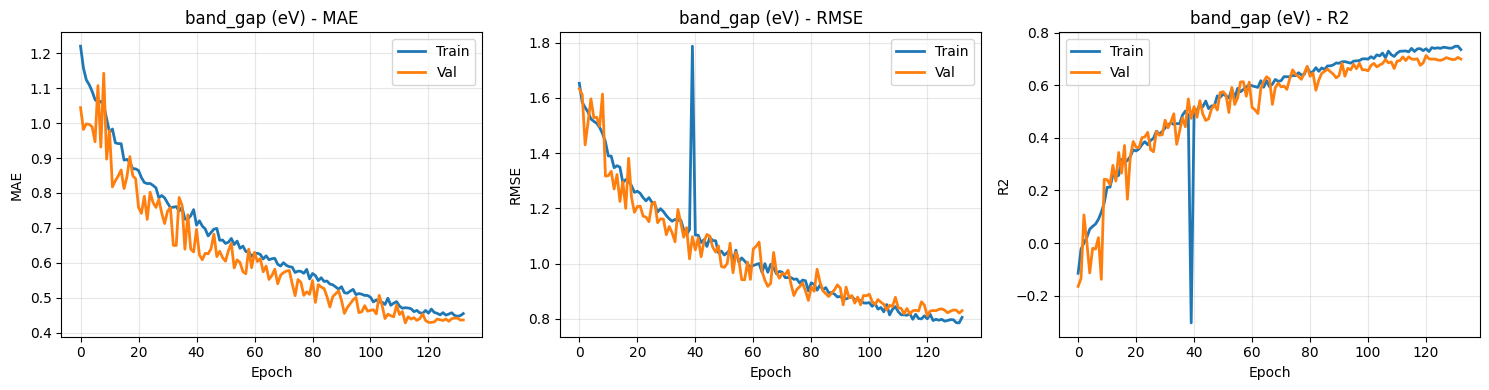


TRAINING COMPLETE!

Best model saved to: best_multitask_model.pt
Visualizations saved to current directory


In [ ]:
for target in available_regression:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    metrics_names = ['MAE', 'RMSE', 'R2']
    for idx, metric in enumerate(metrics_names):
        train_values = [m[metric] for m in history['train_metrics'][target]]
        val_values = [m[metric] for m in history['val_metrics'][target]]

        axes[idx].plot(train_values, label='Train', linewidth=2)
        axes[idx].plot(val_values, label='Val', linewidth=2)
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel(metric)
        axes[idx].set_title(f'{target} - {metric}')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{target.replace(" ", "_")}_metrics.png', dpi=300)
    plt.show()

print("\n" + "="*80)
print("TRAINING COMPLETE!")
print("="*80)
print(f"\nBest model saved to: best_multitask_model.pt")
print(f"Visualizations saved to current directory")